In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
nltk.download('stopwords')
import string
string.punctuation
from unidecode import unidecode #retirar acentos
import regex as re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from scipy.sparse import hstack,csr_matrix
from plotly import figure_factory as ff
import time
from scipy.stats import randint
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anaal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [64]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anaal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Carregamento dos dados

In [65]:
df1 = pd.read_excel(r'tweets_Topics1-2.xlsx').drop('Unnamed: 0',axis=1)
df1 = df1[ (df1.label == 'f') | (df1.label == 't')]

df2 = pd.read_excel(r'tweets_Topics3-5.xlsx').drop('Unnamed: 0',axis=1)
df2 = df2[ (df2.label == 'f') | (df2.label == 't')]

df_total = pd.concat([df1, df2],ignore_index=True)
#Tratamento missing
df_total.retweets.fillna(value=0, inplace=True)

print(f'A base de dados contém {df_total.shape[0]} linhas e {df_total.shape[1]} colunas')

A base de dados contém 730 linhas e 10 colunas


In [66]:
df = pd.DataFrame(
    {'label': df_total['label'].replace(['f','t'],[1,0]),
     'text': df_total.text,
     #'retweets': df_total.retweets
    })

df.head()

,label,text
0,1,Recebi no zap da família que a OMS divulgou um...
1,1,"Não brinquem com o coronavírus, mas eu fiz meu..."
2,0,1. Beber muita água e fazer gargarejo com água...
3,0,"Vai estudar tia, vai ler um livro de Química e..."
4,1,minha prima testou positivo pra covid19 minha ...


In [67]:
features_extra = pd.DataFrame(
                {'qtd_links': df['text'].apply(lambda x:len(re.findall(r'http\S+',x))),
                 'qtd_uppercase': df['text'].apply(lambda x: len([re.findall(r'^[A-Z]+$',w) for w in unidecode(x).split(' ') if len(re.findall(r'^[A-Z]+$',w))>=1])),
                 #'retweets': df['retweets']
    })

features_extra = csr_matrix(features_extra)
features_extra

<730x2 sparse matrix of type '<class 'numpy.int64'>'
	with 476 stored elements in Compressed Sparse Row format>

In [68]:
print('Desbalanceamento:\n', df['label'].value_counts()/len(df))

Desbalanceamento:
 1    0.624658
0    0.375342
Name: label, dtype: float64


## Tratamento do texto

In [69]:
stopwords_pt = nltk.corpus.stopwords.words('portuguese')
#stopwords_pt = stopwords_pt.remove('não')

def clean_text(text):
    
    text = text.lower() #minusculo
    text = unidecode(text) #tirando os acentos
    text = re.sub(r'http\S+', '', text) #tirando os links
    
    #retirando pontuações e números
    regex_filter = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    text = regex_filter.sub('',text)
    
    #Stopwords    
    words = [w for w in text.split(' ') if not w in stopwords_pt]
    
    return " ".join(s for s in words)

In [70]:
#Limpando os tweets
df['text'] = df['text'].apply(lambda x: clean_text(x))

#Criando a matriz tfidf
#tfidf = TfidfVectorizer(ngram_range=(1,1))
#X = tfidf.fit_transform(df.text[X_train.index])
#tfidf.vocabulary_

In [71]:
#X_train, X_test, y_train, y_test = train_test_split(hstack([X, features_extra]), df.label, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df.text, df.label, random_state=42,test_size=0.3)

In [72]:
df.text

0      recebi zap familia oms divulgou vacina caseira...
1      nao brinquem coronavirus fiz proprio remedio c...
2       beber muita agua fazer gargarejo agua morna s...
3      vai estudar tia vai ler livro quimica biologia...
4      prima testou positivo pra covid tia faz gargar...
                             ...                        
725    apesar ter boas intencoes mensagem circula onl...
726    apresentador bom dia rio tendo explicar beber ...
727    novo boato sobre covid aponta agua cha quente ...
728    coronavirus nao sobrevive deg entao so tomar a...
729    fake texto manda beber agua quente evitar coro...
Name: text, Length: 730, dtype: object

## Modelo

In [73]:
models = []

#### LightGBM

In [74]:
#https://neptune.ai/blog/lightgbm-parameters-guide -> explicacao dos hiperparametros
name = 'LGBMClassifier'
model = lgb.LGBMClassifier()
grid = {
    'model__num_leaves': [int(x) for x in np.linspace(start=5, stop=50,num=5)],
    'model__reg_alpha': [0, 1e-1, 1],
    'model__reg_lambda': [0, 1e-1, 1],
    
    'vectorizer': [CountVectorizer(min_df=0.01),
                   TfidfVectorizer(min_df=0.01)],
    
    'vectorizer__ngram_range': [(1,1),(2,2),(3,3)],
    
    'balanced': [None,
                 SMOTE(random_state = 42),
                 RandomOverSampler(random_state = 42),
                 RandomUnderSampler(random_state = 42)]
}
models.append({'name': name, 'model': model, 'grid': grid})

#### SVM

In [75]:
name = 'SVM'
model = SVC(probability=True)
grid = {
    'model__kernel': ['sigmoid', 'rbf', 'poly'],
    'model__gamma': ['scale', 'auto'],
    
    'vectorizer': [CountVectorizer(min_df=0.01),
                   TfidfVectorizer(min_df=0.01)],
    
    'vectorizer__ngram_range': [(1,1),(2,2),(3,3)],
    
    'balanced': [None,
                 SMOTE(random_state = 42),
                 RandomOverSampler(random_state = 42),
                 RandomUnderSampler(random_state = 42)]
}
models.append({'name': name, 'model': model, 'grid': grid})

#### Random Forest

In [76]:
name = 'RandomForest'
model = RandomForestClassifier()
grid = {
    'model__n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=5)],
    'model__criterion': ['gini'], #'entropy'
    
    'vectorizer': [CountVectorizer(min_df=0.01),
                   TfidfVectorizer(min_df=0.01)],
    
    'vectorizer__ngram_range': [(1,1),(2,2),(3,3)],
    
    'balanced': [None,
                 SMOTE(random_state = 42),
                 RandomOverSampler(random_state = 42),
                 RandomUnderSampler(random_state = 42)]
}
models.append({'name': name, 'model': model, 'grid': grid})

#### Naive Bayes

In [77]:
name = 'NaiveBayes'
model = MultinomialNB()
grid = {
    'model__alpha': [1e-9, 1e-6, 1e-3, 0, 1, 1e3, 1e6, 1e9],
    
    'vectorizer': [CountVectorizer(min_df=0.01),
                   TfidfVectorizer(min_df=0.01)],
    
    'vectorizer__ngram_range': [(1,1),(2,2),(3,3)],
    
    'balanced': [None,
                 SMOTE(random_state = 42),
                 RandomOverSampler(random_state = 42),
                 RandomUnderSampler(random_state = 42)]
}
models.append({'name': name, 'model': model, 'grid': grid})

#### AdaBoost

In [78]:
name = 'AdaBoost'
model = AdaBoostClassifier()
grid = {
    'model__n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=5)],
    'model__learning_rate': [round(x,3) for x in np.linspace(start = 0.001, stop=1,num=10)],
    'model__algorithm': ['SAMME', 'SAMME.R'],
    
    'vectorizer': [CountVectorizer(min_df=0.01),
                   TfidfVectorizer(min_df=0.01)],
    
    'vectorizer__ngram_range': [(1,1),(2,2),(3,3)],
    
    'balanced': [None,
                 SMOTE(random_state = 42),
                 RandomOverSampler(random_state = 42),
                 RandomUnderSampler(random_state = 42)]
}

models.append({'name': name, 'model': model, 'grid': grid})

### Train

In [79]:
#concat = FunctionTransformer(lambda x: hstack([x, features_extra[X_train.index.tolist()]])  if  x.shape[0] == X_train.shape[0]  else hstack([x, features_extra[:x.shape[0]]])) 

def train_test(mat, X, y):
    model = mat['model']
    name = mat['name']
    grid = mat['grid']
    
    print(f'Começando {name}.')
    ini = time.time()
    
  
    pipe = Pipeline([
        ('vectorizer', 'passthrough'),
        ('balanced', 'passthrough'),
        ('model', model)
    ])
    
    rscv = GridSearchCV(
        pipe,
        param_grid = grid,
        scoring = 'f1',
        cv = 5,
        verbose = 10,
        n_jobs = -1,
    ).fit(X,y)
    
    fim = time.time()
    
    print(f'Término {name} | Score: {round(rscv.best_score_,3)} | Time: {rscv.refit_time_}')
    
    return {'name':name, 'object': rscv}

In [80]:
%%time
results = [train_test(mat, X_train, y_train) for mat in models]

info_model = []
info_values = []
info_time = []

for i, v in enumerate(results):
        
    info_model.append(results[i]['name'])
    info_values.append(round(results[i]['object'].best_score_,3))
    info_time.append(results[i]['object'].refit_time_)
    
dados = pd.DataFrame({'Model': info_model, 'Score': info_values, 'Time': info_time})    
fig = ff.create_table(dados, height_constant=20)
fig.show()

Começando LGBMClassifier.
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1991s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1963s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:   21.5s
[Parallel(n_jo

Término LGBMClassifier | Score: 0.856 | Time: 0.15025043487548828
Começando SVM.
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1823s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 314 tas

Término SVM | Score: 0.89 | Time: 0.16823768615722656
Começando RandomForest.
Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1

Término RandomForest | Score: 0.893 | Time: 3.615497350692749
Começando NaiveBayes.
Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0670s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1666s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 308 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 436 tasks      | elapsed:    3.9s
[Parallel(n_jo

Término NaiveBayes | Score: 0.873 | Time: 0.029386520385742188
Começando AdaBoost.
Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  1.2min
[Paralle

[Parallel(n_jobs=-1)]: Done 9369 tasks      | elapsed: 57.7min
[Parallel(n_jobs=-1)]: Done 9506 tasks      | elapsed: 58.4min
[Parallel(n_jobs=-1)]: Done 9645 tasks      | elapsed: 59.1min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 59.9min
[Parallel(n_jobs=-1)]: Done 9925 tasks      | elapsed: 60.6min
[Parallel(n_jobs=-1)]: Done 10066 tasks      | elapsed: 61.4min
[Parallel(n_jobs=-1)]: Done 10209 tasks      | elapsed: 62.3min
[Parallel(n_jobs=-1)]: Done 10352 tasks      | elapsed: 63.3min
[Parallel(n_jobs=-1)]: Done 10497 tasks      | elapsed: 64.2min
[Parallel(n_jobs=-1)]: Done 10642 tasks      | elapsed: 65.0min
[Parallel(n_jobs=-1)]: Done 10789 tasks      | elapsed: 65.9min
[Parallel(n_jobs=-1)]: Done 10936 tasks      | elapsed: 67.0min
[Parallel(n_jobs=-1)]: Done 11085 tasks      | elapsed: 68.1min
[Parallel(n_jobs=-1)]: Done 11234 tasks      | elapsed: 69.3min
[Parallel(n_jobs=-1)]: Done 11385 tasks      | elapsed: 70.4min
[Parallel(n_jobs=-1)]: Done 11536 tasks      

Término AdaBoost | Score: 0.89 | Time: 1.6470293998718262


Wall time: 1h 21min 37s


## Validação

In [62]:
info_model = []
info_time = []
result = pd.DataFrame(columns=['model','F1 Grid', 'Acurácia','F1 Score','Precisao', 'Recall'])
result_roc = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

for i, v in enumerate(results):
        
    info_model.append(results[i]['name'])
    info_time.append(results[i]['object'].refit_time_)
    info_values = round(results[i]['object'].best_score_,3)
    
    model = results[i]['object'].best_estimator_
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test) 
    y_proba = model.predict_proba(X_test)[:,1]

    acc = round(accuracy_score(y_test, y_pred),3)
    f1 = round(f1_score(y_test, y_pred),3)
    pc = round(precision_score(y_test, y_pred),3)
    re = round(recall_score(y_test, y_pred),3)
    
    result = result.append({'model':results[i]['name'],
                            'F1 Grid': info_values,
                                        'Acurácia':acc, 
                                        'F1 Score':f1, 
                                        'Precisao':pc,
                                        'Recall': re}, ignore_index=True)
    
    fpr, tpr, _ = roc_curve(y_test,  y_proba)
    auc = roc_auc_score(y_test, y_proba)
    
    result_roc = result_roc.append({'classifiers':results[i]['name'],
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

    
result_roc.set_index('classifiers', inplace=True)    
fig = ff.create_table(result, height_constant=20)
fig.show()

In [42]:
print(results[2]['name'])
results[2]['object'].best_estimator_

RandomForest


Pipeline(steps=[('vectorizer', CountVectorizer(min_df=0.01)),
                ('balanced', None),
                ('model',
                 RandomForestClassifier(criterion='entropy',
                                        n_estimators=775))])

In [43]:
results[2]['object'].best_estimator_['model']

RandomForestClassifier(criterion='entropy', n_estimators=775)

### ROC Curve

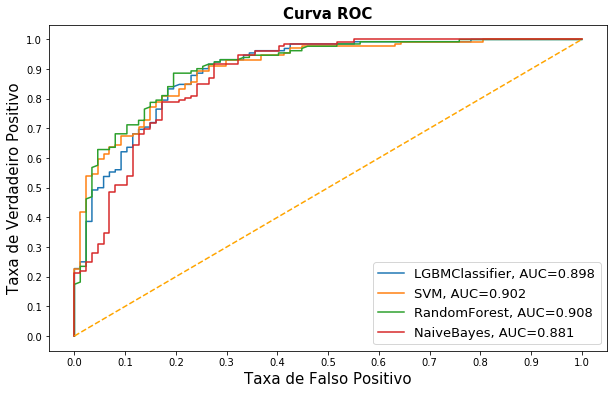

In [44]:
fig = plt.figure(figsize=(10,6))

for i in result_roc.index:
    plt.plot(result_roc.loc[i]['fpr'], 
             result_roc.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_roc.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Taxa de Falso Positivo", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("Taxa de Verdadeiro Positivo", fontsize=15)

plt.title('Curva ROC', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()